## 1. Persiapan Data

### 1.1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

### 1.2. Authorization

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fazlurachman","key":"672136a0a0f47e05198a4873c0be0968"}'}

### 1.3. Download Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d itachi9604/disease-symptom-description-dataset

Dataset URL: https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/30.1k [00:00<?, ?B/s]
100% 30.1k/30.1k [00:00<00:00, 134MB/s]


### 1.4. Unzip Dataset

In [ ]:
with ZipFile('disease-symptom-description-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


### 1.5. Load Dataset

In [ ]:
# Dataset utama (gejala dan label penyakit)
df_main = pd.read_csv('dataset/dataset.csv')

# Dataset pendukung
df_severity = pd.read_csv('dataset/Symptom-severity.csv')
df_description = pd.read_csv('dataset/symptom_Description.csv')
df_precaution = pd.read_csv('dataset/symptom_precaution.csv')


## 2. Exploratory Data Analysis (EDA)

###  2.1. Cek Struktur dan Ringkasan Data

In [ ]:
print(df_main.shape)
print(df_main.info())
print(df_main.head())


(4920, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB
None
            Disease   Symptom_1   

### 2.2. Cek Missing Value

In [ ]:
df_main.isnull().sum()


,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,348
Symptom_5,1206
Symptom_6,1986
Symptom_7,2652
Symptom_8,2976
Symptom_9,3228


### 2.3. Distribusi Penyakit

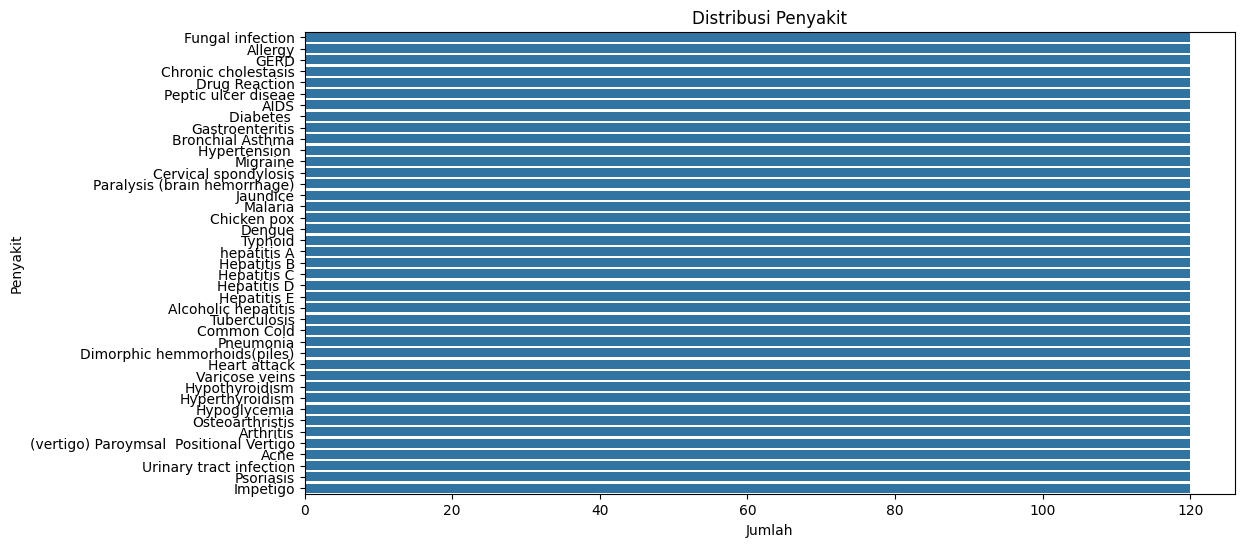

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='Disease', data=df_main, order=df_main['Disease'].value_counts().index)
plt.title("Distribusi Penyakit")
plt.xlabel("Jumlah")
plt.ylabel("Penyakit")
plt.show()


### 2.4. Jumlah Gejala Tiap Kasus

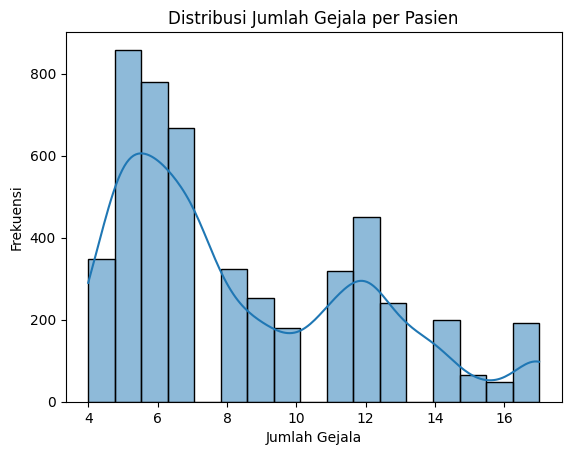

In [ ]:
def count_symptoms(row):
    return row.notnull().sum()

df_main['num_symptoms'] = df_main.iloc[:, :-1].apply(count_symptoms, axis=1)

sns.histplot(df_main['num_symptoms'], bins=17, kde=True)
plt.title("Distribusi Jumlah Gejala per Pasien")
plt.xlabel("Jumlah Gejala")
plt.ylabel("Frekuensi")
plt.show()


## 3. Data Preprocessing

### 3.1. Menangani Missing Value

In [ ]:
# Isi missing value dengan 'none' dan ubah jadi lowercase
symptom_cols = [col for col in df_main.columns if "Symptom_" in col]
for col in symptom_cols:
    df_main[col] = df_main[col].fillna('none').str.strip().str.lower()


### 3.2. Normalisasi Nama Gejala

In [ ]:
for col in symptom_cols:
    df_main[col] = df_main[col].str.replace('_', ' ').str.strip().str.lower()

### 3.3. Gabungkan dengan Severity Score

In [ ]:
# Load data severity
severity_map = dict(zip(df_severity['Symptom'].str.lower().str.strip(), df_severity['weight']))

# Ubah symptom menjadi skor numerik
def encode_symptom(symptom):
    return severity_map.get(symptom, 0)

# Terapkan ke semua kolom symptom
for col in symptom_cols:
    df_main[col] = df_main[col].apply(encode_symptom)


### 3.4. Encoding Label Target

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_main['Disease'] = le.fit_transform(df_main['Disease'])


### 3.5. Pemisahan Fitur dan Label

In [ ]:
X = df_main[symptom_cols]
y = df_main['Disease']


### 3.6. Split Data untuk Pelatihan dan Pengujian

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Modelling

### 4.1 Melatih dan Membandingkan Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
    print("-" * 30)


Model: Random Forest
Accuracy: 0.8313008130081301
F1 Score: 0.8120954053219399
------------------------------
Model: Naive Bayes
Accuracy: 0.7479674796747967
F1 Score: 0.7209211530948845
------------------------------
Model: SVM
Accuracy: 0.7947154471544715
F1 Score: 0.7765866585134185
------------------------------
Model: KNN
Accuracy: 0.8465447154471545
F1 Score: 0.8237511435807119
------------------------------


### 4.2 Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.8414634146341463


In [ ]:
best_rf = grid_search.best_estimator_

### 4.3 Evaluasi Lanjut (Confusion Matrix & Classification Report)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.00      0.00      0.00        30
           2       1.00      1.00      1.00        24
           3       0.92      0.96      0.94        25
           4       0.96      0.96      0.96        24
           5       0.00      0.00      0.00        23
           6       1.00      0.94      0.97        33
           7       1.00      0.61      0.76        23
           8       1.00      1.00      1.00        21
           9       0.83      1.00      0.91        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       0.84      0.90      0.87        29
          14       0.00      0.00      0.00        24
          15       0.41      0.84      0.55        19
          16       1.00      1.00      1.00        28
          17       1.00    

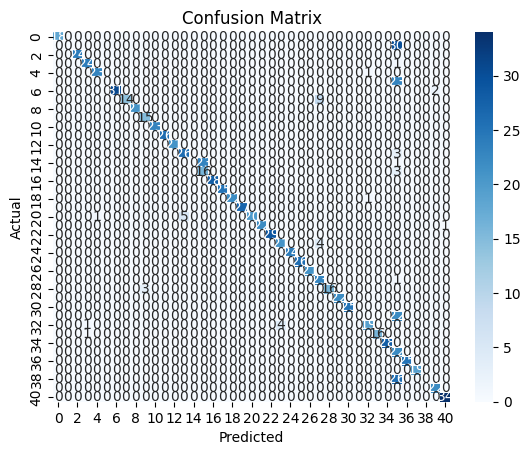

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### 4.4 Simpan Model Terbaik

In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load model dan label encoder
model = joblib.load("best_model.pkl")
le = joblib.load("label_encoder.pkl")

# Load data severity
df_severity_loaded = pd.read_csv('dataset/Symptom-severity.csv')
severity_map = dict(zip(df_severity_loaded['Symptom'].str.lower().str.strip(), df_severity_loaded['weight']))

# Tentukan fitur yang digunakan saat pelatihan
try:
    feature_cols_in_model = model.feature_names_in_
except AttributeError:
    feature_cols_in_model = [f'Symptom_{i}' for i in range(1, 18)]

def predict_disease_from_symptoms(input_symptoms_list):
    input_df = pd.DataFrame(0, index=[0], columns=feature_cols_in_model)
    normalized_input = [sym.strip().lower().replace('_', ' ') for sym in input_symptoms_list]

    for i, symptom in enumerate(normalized_input):
        if i < len(feature_cols_in_model):
            severity_score = severity_map.get(symptom, 0)
            input_df.iloc[0, i] = severity_score

    prediction = model.predict(input_df)[0]
    predicted_label = le.inverse_transform([prediction])[0]
    return predicted_label


In [ ]:
# Contoh penggunaan:
gejala_pengguna = ['headache', 'fatigue', 'vomiting', 'nausea', 'dizziness', 'cough', 'fever']
hasil_prediksi = predict_disease_from_symptoms(gejala_pengguna)
print("Penyakit yang diprediksi:", hasil_prediksi)

Penyakit yang diprediksi: Pneumonia
